In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## torch FRCNN


Faster R-CNN (FRCNN) is a deep learning model specifically designed for object detection tasks, meaning it identifies and classifies multiple objects within an image and draws bounding boxes around them. 
#### Output:

The final output includes bounding box coordinates, classes, and a class label for each detected object in the image.

In [ ]:
### Import Libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.transforms import functional as F
import torchvision.transforms as transforms

from PIL import Image

import cv2

#from utils.helper import fn_plot_confusion_matrix, fn_plot_tf_hist

In [3]:
# Some basic parameters

inpDir = '' # location where input data is stored
outDir = '' # location to store outputs
subDir = '' # location of the images
modelDir = ''
altName = 'rcnn'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
EPOCHS = 100 # number of cycles to run
THRESHOLD = 0.8


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,12),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Selecting the device

In [5]:
device = "cpu"
print(f"Using {device} device")

Using cpu device


# Helper Functions

#### The COCO Dataset Category Names

In [6]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Create different colors for each class.
COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))
# Define the torchvision image transforms.
transform = transforms.Compose([
    transforms.ToTensor(),
])

##### Predict Function

In [7]:
def predict(image, model, device, detection_threshold = 0.5, coco_names=COCO_INSTANCE_CATEGORY_NAMES):
    """
    Predict the output of an image after forward pass through
    the model and return the bounding boxes, class names, and
    class labels.
    """
    # Transform the image to tensor.
    image = transform(image).to(device)
    # Add a batch dimension.
    image = image.unsqueeze(0)
    # Get the predictions on the image.
    with torch.no_grad():
        outputs = model(image)
    # Get score for all the predicted objects.
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # Get all the predicted bounding boxes.
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # Get boxes above the threshold score.
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    labels = outputs[0]['labels'][:len(boxes)]
    # Get all the predicted class names.
    pred_classes = [coco_names[i] for i in labels.cpu().numpy()]
    return boxes, pred_classes, labels

In [8]:
def draw_boxes(boxes, classes, labels, image):
    '''`
    Draws bounding boxes with labels on an image to represent detected objects.

    Args:
        boxes (list): A list of bounding box coordinates for each detected object,
                    where each box is represented by [x_min, y_min, x_max, y_max].
        classes (list): A list of class names corresponding to each bounding box.
        labels (list): A list of label indices for each detected object; these are
                    used to pick specific colors for each class.
        image (numpy array): The image on which to draw the bounding boxes.

    Returns:
        image (numpy array): The modified image with bounding boxes and labels drawn on it.
    '''

    # Determine line width for the bounding boxes based on image dimensions.
    # This sets the line width to a fraction of the sum of image height and width,
    # with a minimum width of 2 to ensure visibility.
    lw = max(round(sum(image.shape) / 2 * 0.001), 2)

    # Determine font thickness, set to one less than line width but with a minimum of 1.
    tf = max(lw - 1, 2)

    # Loop through each bounding box to draw it on the image.
    for i, box in enumerate(boxes):
        # Select a color for the bounding box from the COLORS array, using the label index.
        # COLORS is a predefined array where each index corresponds to a specific color.
        color = COLORS[labels[i]]

        # Draw the bounding box as a rectangle on the image.

        cv2.rectangle(
            img=image,
            pt1=(int(box[0]), int(box[1])), # top-left corner of the box.
            pt2=(int(box[2]), int(box[3])), # bottom-right corner of the box.
            color=color[::-1],              # Reversed to BGR for OpenCV
            thickness=lw                    # set to lw to maintain consistency with text.
        )

        # Add text to label the bounding box with the class name.
        cv2.putText(
            img=image,
            text=classes[i],
            org=(int(box[0]), int(box[1] - 5)),  # 5 pixels above the top-left corner
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw / 2,                    # proportional to line width for a balanced appearance.
            color=color[::-1],                   # Reversed to BGR for OpenCV
            thickness=tf,                        # set to tf for good legibility.
            lineType=cv2.LINE_AA                 # anti-aliased text for smoothness.
        )

    # Return the modified image with all bounding boxes and labels.
    return image

In [11]:
# Load a pre-trained Faster R-CNN model
def get_model(device='cpu'):

    # Load the model.
    model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')

    # Load the model onto the computation device.
    model = model.eval().to(device)

    return model

In [12]:
model = get_model(device)

## Load Image

In [13]:
# Load the input image and apply transformations
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")

    # Create a BGR copy of the image for annotation.
    image_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    return image, image_bgr


In [14]:
imgName = 'traffic.jpg' 
# Load an example image
image_path = os.path.join(inpDir, subDir, imgName)  # specify your image path
image, image_bgr = load_image(imgName)

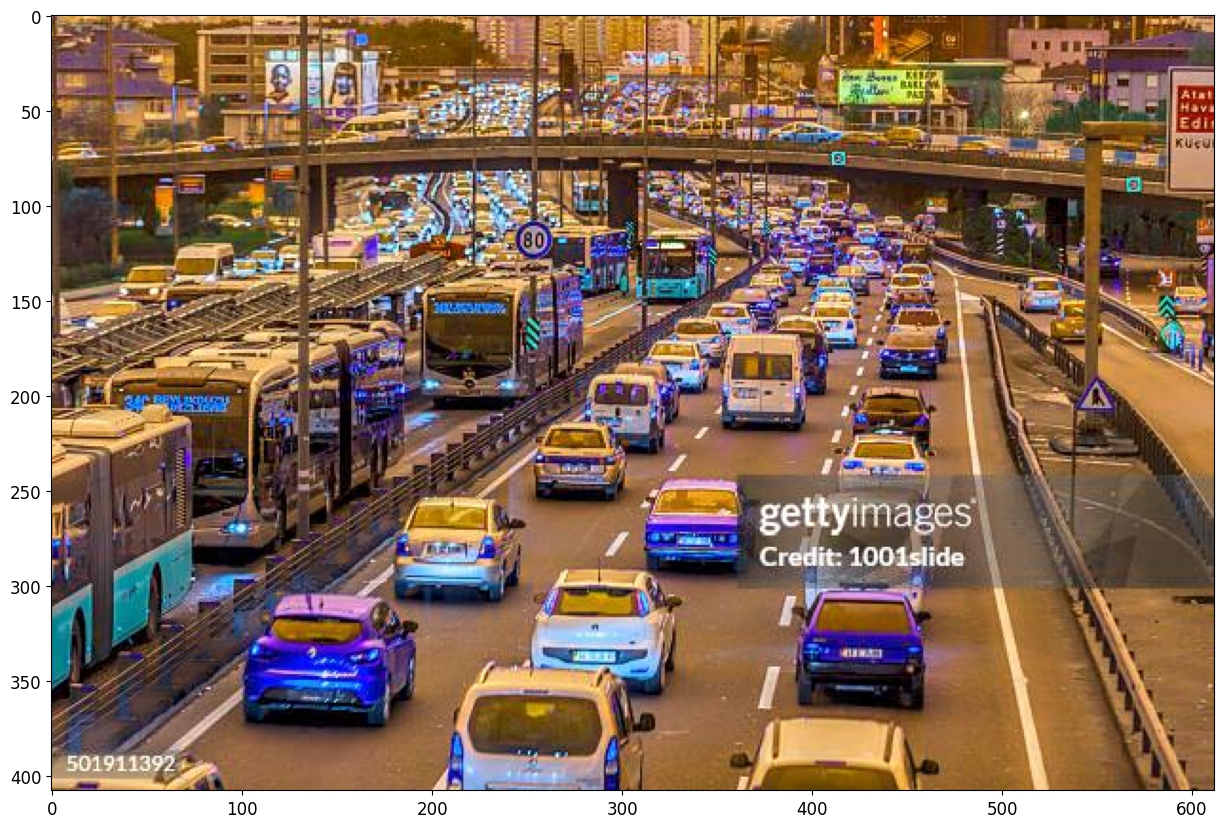

In [15]:
plt.imshow(image_bgr)

In [16]:
# Detect outputs.
with torch.no_grad():
    boxes, classes, labels = predict(image, model, device, detection_threshold= THRESHOLD)
# Draw bounding boxes.
image = draw_boxes(boxes, classes, labels, image_bgr)


In [17]:
type(image_bgr)

numpy.ndarray

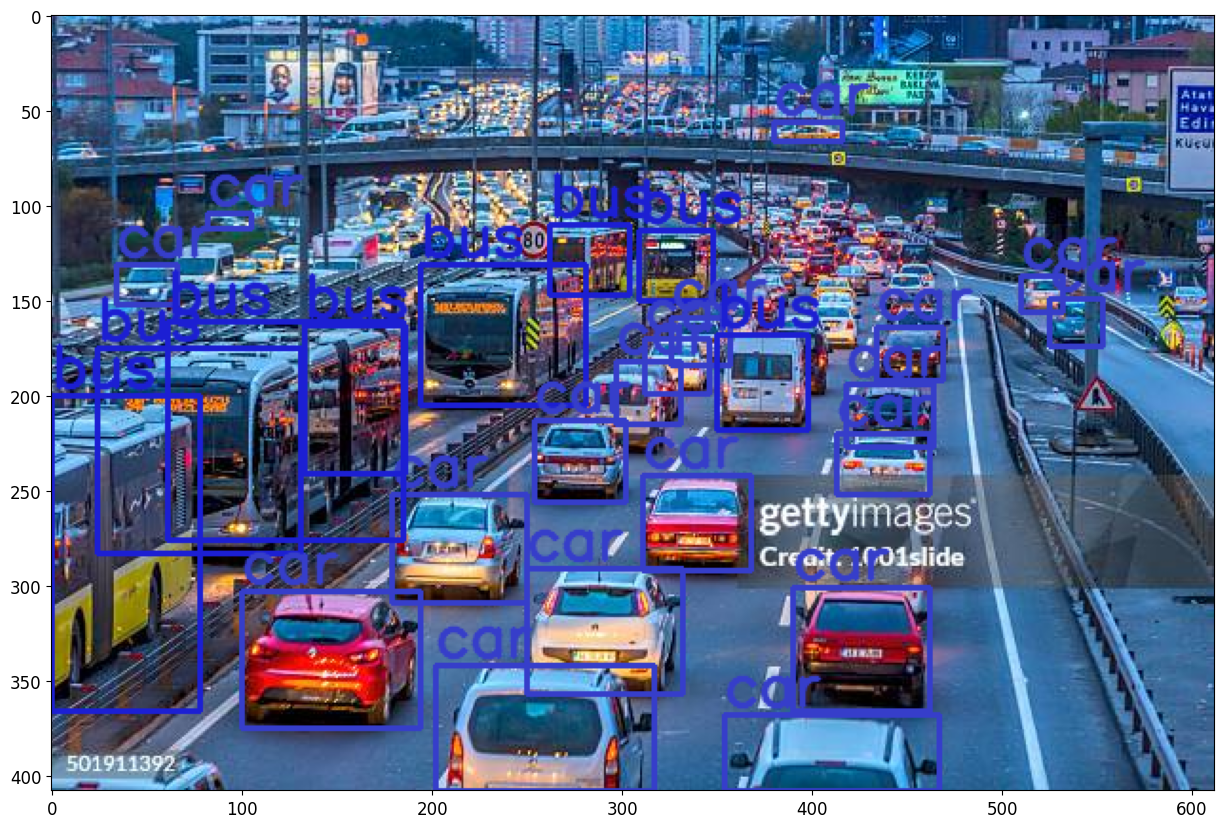

In [18]:
rgbIm = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(rgbIm);

In [23]:
vidName = 'VID_20240320080723_F.MOV' #'VID_20240320164819_F.MOV' # 'VID_20240320164919_F.MOV'
vidFilePath = os.path.join(inpDir, subDir, vidName)

cap = cv2.VideoCapture(vidName)

In [24]:
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')
# Get the frame width and height.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# for saving the file
save_name = f"{vidFilePath[-1].split('.')[0]}_t{''.join(str(THRESHOLD).split('.'))}_{altName}"
# Define codec and create VideoWriter object .
out = cv2.VideoWriter(os.path.join(outDir, f"{save_name}.mp4"),
                      cv2.VideoWriter_fourcc(*'mp4v'), 30,
                      (frame_width, frame_height))
frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.

In [ ]:
# Read until end of video.
while(cap.isOpened):
    # Capture each frame of the video.
    ret, frame = cap.read()
    if ret:
        frame_copy = frame.copy()
        frame_copy = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)
        # Get the start time.
        start_time = time.time()
        with torch.no_grad():
            # Get predictions for the current frame.
            boxes, classes, labels = predict( frame, model, device, THRESHOLD)

        # Draw boxes and show current frame on screen.
        image = draw_boxes(boxes, classes, labels, frame)
        # Get the end time.
        end_time = time.time()
        # Get the fps.
        fps = 1 / (end_time - start_time)
        # Add fps to total fps.
        total_fps += fps
        # Increment frame count.
        frame_count += 1
        # Write the FPS on the current frame.
        cv2.putText(
            img=image,
            text=f"{fps:.3f} FPS",
            org=(15, 30),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(0, 255, 0),
            thickness=2,
            lineType=cv2.LINE_AA
        )
        # Convert from BGR to RGB color format.
        cv2.imshow('image', image)
        out.write(image)
        # Press `q` to exit.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
# Release VideoCapture().
cap.release()
# Close all frames and video windows.
cv2.destroyAllWindows()
# Calculate and print the average FPS.
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")
